**Spatial Aliasing**
- $d < \frac{c}{2f}$

    - $d$ : microphone distance
    - $f$ : specific frequency
    - $c$ : sound of speed

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
from scipy.signal import find_peaks


folder = "data/240604/103.5"
sr = 48000

# bottom, top
sig1, _ = librosa.load(folder + "/" + "hal_in_pure_24_4ch_48k_1.wav", sr=None)
sig2, _ = librosa.load(folder + "/" + "hal_in_pure_24_4ch_48k_2.wav", sr=None)
sig3, _ = librosa.load(folder + "/" + "hal_in_pure_24_4ch_48k_3.wav", sr=None)
# sig1, _ = librosa.load(folder + "/" + "sig1.wav", sr=None)
# sig2, _ = librosa.load(folder + "/" + "sig2.wav", sr=None)

## GCC-PHAT ##
def gcc_phat(sig, refsig, sr):
    n = sig.size + refsig.size
    
    SIG = np.fft.rfft(sig, n=n)
    REFSIG = np.fft.rfft(refsig, n=n)
    
    R = SIG * np.conj(REFSIG)
    cc = np.fft.irfft(R / np.abs(R))
    
    # cross-correlation = sample delay
    # TDoA = sample delay / sampling rate

    # max_shift -> How the signal is delayed relative to another
    # cc -> consider all possible delays in the range -max shift ~ +max_shift
    
    # Due to FFT, the cross-correlation function has circular properties.
    # The process of converting linear convolution result is necessary.
    # So, the result of the cross-correlation function is shifted and converted to center-based form.
    
    sample_delay = 0
    max_shift = n // 2
    cc = np.concatenate((cc[-max_shift:], cc[:max_shift]))
    sample_delay = np.argmax(cc) - max_shift
    tdoa = sample_delay / float(sr)

    return cc, tdoa

# tdoa = cos(doa) * distance / sound_speed
distance = 0.161
sound_speed = 343.2
cc_12, tdoa_12 = gcc_phat(sig1, sig2, sr)
cc_13, tdoa_13 = gcc_phat(sig1, sig3, sr)
cc_23, tdoa_23 = gcc_phat(sig2, sig3, sr)
doa_12 = np.arccos(tdoa_12 * sound_speed / distance)
doa_13 = np.arccos(tdoa_13 * sound_speed / distance)
doa_23 = np.arccos(tdoa_23 * sound_speed / distance)
print(f"Azimuth 12: {np.degrees(doa_12)-90:.4f}")
print(f"Azimuth 13: {np.degrees(doa_13)-90:.4f}")
print(f"Azimuth 23: {np.degrees(doa_23)-90:.4f}")

Azimuth 12: 20.8106
Azimuth 13: 10.2323
Azimuth 23: -10.2323


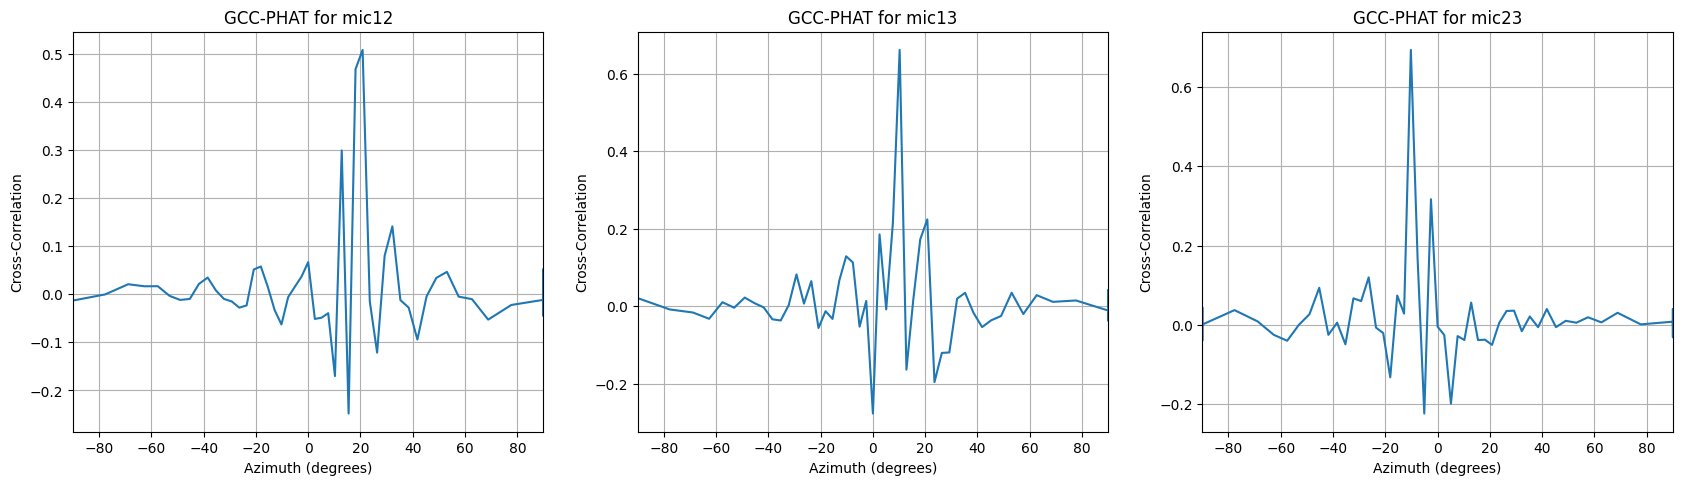

In [29]:
# subplot 그리기
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# 첫 번째 subplot
max_lag = cc_12.size // 2
lags = np.arange(-max_lag, max_lag) / float(sr)
angles = np.degrees(np.arccos(np.clip(lags * sound_speed / distance, -1, 1))) - 90

axs[0].plot(angles, cc_12)
axs[0].set_xlabel('Azimuth (degrees)')
axs[0].set_ylabel('Cross-Correlation')
axs[0].set_xlim(-90, 90)
axs[0].grid(True)
axs[0].set_title('GCC-PHAT for mic12')

# 두 번째 subplot
max_lag = cc_13.size // 2
lags = np.arange(-max_lag, max_lag) / float(sr)
angles = np.degrees(np.arccos(np.clip(lags * sound_speed / distance, -1, 1))) - 90

axs[1].plot(angles, cc_13)
axs[1].set_xlabel('Azimuth (degrees)')
axs[1].set_ylabel('Cross-Correlation')
axs[1].set_xlim(-90, 90)
axs[1].grid(True)
axs[1].set_title('GCC-PHAT for mic13')

# 세 번째 subplot
max_lag = cc_23.size // 2
lags = np.arange(-max_lag, max_lag) / float(sr)
angles = np.degrees(np.arccos(np.clip(lags * sound_speed / distance, -1, 1))) - 90

axs[2].plot(angles, cc_23)
axs[2].set_xlabel('Azimuth (degrees)')
axs[2].set_ylabel('Cross-Correlation')
axs[2].set_xlim(-90, 90)
axs[2].grid(True)
axs[2].set_title('GCC-PHAT for mic23')

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.4)
plt.show()